In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision.datasets import MNIST


In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 10


random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
mnist_trainset = MNIST("C:\\Users\\sadri\\Documents\\deepLearningProject\\", train=True, download=True)
mnist_testset = MNIST("C:\\Users\\sadri\\Documents\\deepLearningProject\\", train=False, download=True)

In [4]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 1, 28, 28).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 1, 28, 28).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 1, 28, 28).float()
targets_test = mnist_testset.targets[:500]

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 1, 28, 28])
targets_train torch.Size([1000])
x_valid torch.Size([500, 1, 28, 28])
targets_valid torch.Size([500])
x_test torch.Size([500, 1, 28, 28])
targets_test torch.Size([500])


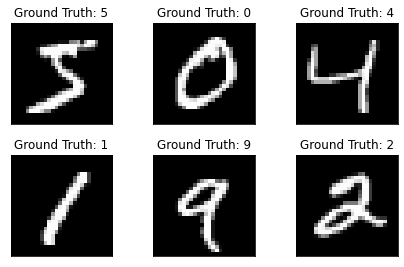

In [5]:
import matplotlib.pyplot as plt

example_data = mnist_trainset.data[:6].view(-1,1,28,28)
example_targets = targets_train[:6]

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [6]:
if torch.cuda.is_available():
    print('try to use cuda!')
else:
    print('sorry, but no cuda found!')

try to use cuda!


In [7]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [8]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            print(input_channels, num_channels)
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [9]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), # kernel_size, ... :: 7, 2, 3
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

64 128
128 256
256 512


In [10]:
X = torch.rand(size=(56, 1, 28, 28))
print(net)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

for layer in b2:
    print(layer.conv1.weight.shape)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [11]:
#--> momentum added to SGD optimizer
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) 
#--> Adam optimizer with L2 regularization instead of SGD optimizer
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-4) 
criterion = nn.CrossEntropyLoss()

In [12]:
batch_size = 10
num_epochs = 50
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
num_samples_test = x_test.shape[0]
num_batches_test = num_samples_test // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []


print(num_batches_train)
get_slice = lambda i, size: range(i * size, (i + 1) * size)
slce = get_slice(5, batch_size)
print(x_train.shape)
for i in range(num_batches_train):
    slce = get_slice(i, batch_size)
    # print(i, slce)
    x_batch = x_train[slce]
    # print(x_batch.shape)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print(net)

100
torch.Size([1000, 1, 28, 28])
cuda:0
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [15]:
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('training on', device)
net.to(device)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = x_train[slce]
        x_batch = x_batch.to(device)
        
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        target_batch = target_batch.to(device)
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = x_train[slce].to(device)
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        train_targs += list(targets_train[slce])
        predscpu = preds.cpu()
        train_preds += list(predscpu.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = x_valid[slce].to(device)
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        predscpu = preds.cpu()
        val_preds += list(predscpu.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        test_preds, test_targs = [], []
        for i in range(num_batches_test):
            slce = get_slice(i, batch_size)
            x_batch = x_test[slce].to(device)

            output = net(x_batch)
            preds = torch.max(output, 1)[1]
            predscpu = preds.cpu()
            test_preds += list(predscpu.data.numpy())
            test_targs += list(targets_test[slce])
        test_acc_cur = accuracy_score(test_targs, test_preds)
        test_acc.append(test_acc_cur)
        
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f, Test acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur, test_acc_cur))

training on cuda:0
Epoch  1 : Train Loss 3.366620 , Train acc 0.942000, Valid acc 0.882000, Test acc 0.910000
Epoch 11 : Train Loss 0.898144 , Train acc 0.951000, Valid acc 0.872000, Test acc 0.896000
Epoch 21 : Train Loss 0.002353 , Train acc 1.000000, Valid acc 0.930000, Test acc 0.964000
Epoch 31 : Train Loss 1.748306 , Train acc 0.972000, Valid acc 0.882000, Test acc 0.890000
Epoch 41 : Train Loss 0.001633 , Train acc 1.000000, Valid acc 0.922000, Test acc 0.964000


In [ ]:
print(net[1][0].conv1.weight[0,0,:,:])
print(net[1][0].conv2.weight[0,0,:,:])
net[1][0].conv1 = net[1][0].conv2
print(net[1][0].conv1.weight[0,0,:,:])
print(net[1][0].conv2.weight[0,0,:,:])

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

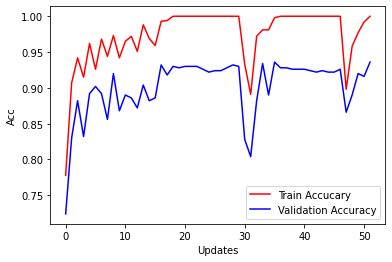

In [17]:
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')